# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Conducting a round of differencing

# 1. importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. 

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'a2D3vwTbtdaZ5DoeaPAx'

# creating path and importing dataset df_kc

In [3]:
path = r'C:\Users\Apex PC\Desktop\DATA ANALYSIS\Achievement 6 project\df_kc.csv'

In [4]:
path

'C:\\Users\\Apex PC\\Desktop\\DATA ANALYSIS\\Achievement 6 project\\df_kc.csv'

In [5]:
df_kc = pd.read_csv(os.path.join(path,))

In [6]:
df_kc.head()

Unnamed: 0.1  Unnamed: 0          id        date     price  bedrooms  \
0             0           0  7129300520  2014-10-13  221900.0         3   
1             1           1  6414100192  2014-12-09  538000.0         3   
2             2           2  5631500400  2015-02-25  180000.0         2   
3             3           3  2487200875  2014-12-09  604000.0         4   
4             4           4  1954400510  2015-02-18  510000.0         3   

   bathrooms  sqft_living  sqft_lot  floors  ...  sqft_above  sqft_basement  \
0       1.00         1180      5650     1.0  ...        1180              0   
1       2.25         2570      7242     2.0  ...        2170            400   
2       1.00          770     10000     1.0  ...         770              0   
3       3.00         1960      5000     1.0  ...        1050            910   
4       2.00         1680      8080     1.0  ...        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  price category  
0        5650       Low price  
1        7639    Middle price  
2        8062       Low price  
3        5000      High price  
4        7503    Middle price  

[5 rows x 24 columns]

In [7]:
df_kc.shape

(21613, 24)

In [8]:
df_kc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'date', 'price', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'price category'],
      dtype='object')

In [9]:
type(df_kc)

pandas.core.frame.DataFrame

### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:

# Convert date column to datetime
df_kc['date'] = pd.to_datetime(df_kc['date'])

# Filter between Jan 1, 2014 and Dec 31, 2015
df_sub = df_kc[(df_kc['date'] >= '2014-01-01') & (df_kc['date'] <= '2015-12-31')]

# Drop unrealistic prices (e.g., under $50,000 or over $2,000,000)
df_sub = df_sub[(df_sub['price'] > 50000) & (df_sub['price'] < 2000000)]

# Reset index for clean slicing
df_sub = df_sub.reset_index(drop=True)

# Set date as index
df_sub.set_index('date', inplace=True)


# I selected data between January 2014 and December 2015 because the dataset contains house sales in that period. Filtering within this range ensures I capture consistent market behavior without including any forecasted or outdated historical values. I also removed price outliers (below $50,000 and above $2M) to prevent them from skewing the time series trends. This cleaned subset allows for more accurate decomposition and interpretation.

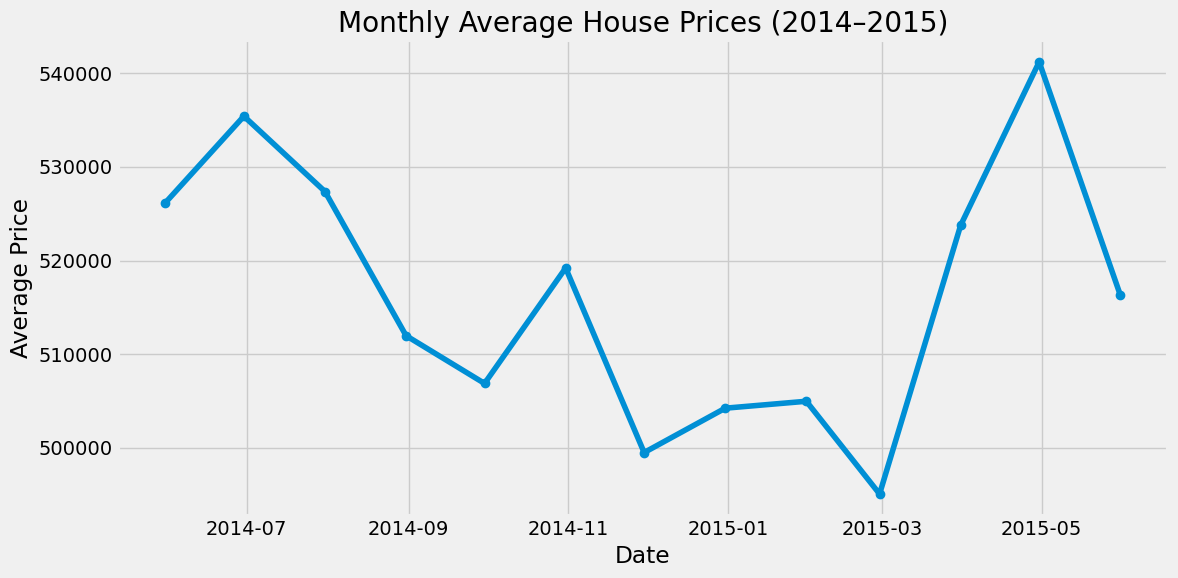

In [11]:

# Resample monthly and calculate mean price
monthly_avg = df_sub['price'].resample('M').mean()

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg, marker='o')
plt.title('Monthly Average House Prices (2014–2015)')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Time-series analysis: decomposition

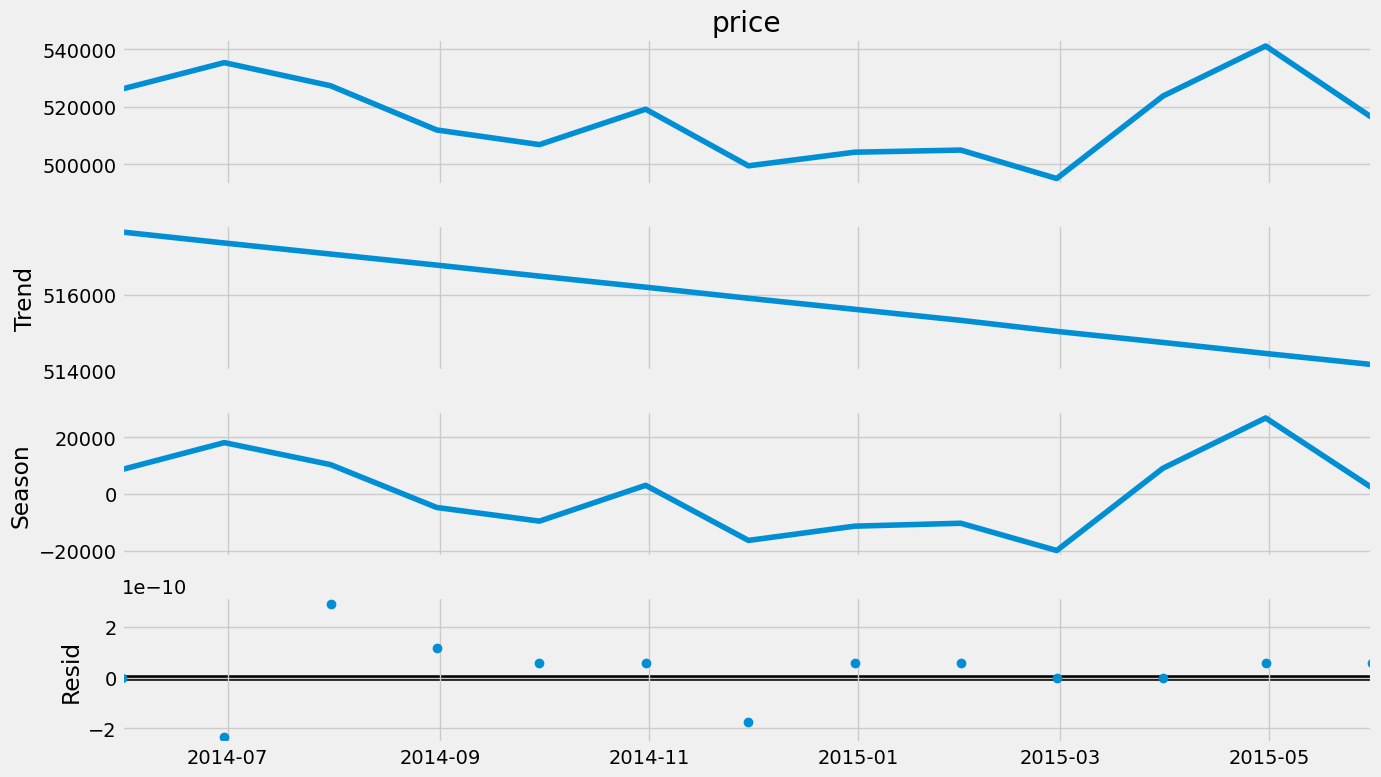

In [13]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(monthly_avg, period=12)  # Assume annual seasonality
res = stl.fit()

# Plot components
fig = res.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.show()


# Decomposition Analysis

# The STL decomposition breaks the price series into level, trend, season, and residual components:
# Level: The first chart in the figure above is the data itself which includes all of its components. 

# Trend: Here trend differs from level even after smoothing was performed. It also shows a steady downward pattern in average house prices from early 2014 through 2015, indicating a decreasing housing market.

# Seasonality: Here minor seasonal fluctuations are seen which suggests slight monthly variation, possibly linked to buying cycles or weather-related activity.

# Residuals: Show small random noise from the year and month 2014-07 to 2015-03 and then picks up 2015-05.


### 4. Testing for stationarity

In [16]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller  # Import the adfuller() function

def dickey_fuller(timeseries):  # Define the function
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries.dropna(), autolag='AIC')
    result = pd.Series(test[0:4], index=[
        'Test Statistic',
        'p-value',
        'Number of Lags Used',
        'Number of Observations Used'
    ])
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    print(result)

# Apply the test using the function on your resampled time series
dickey_fuller(monthly_avg)


Dickey-Fuller Stationarity test:
Test Statistic                 -2.156553
p-value                         0.222390
Number of Lags Used             0.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


# In this case, I am using a significance level of 5 percent. Looking at the “Critical Value (5%)” in the results, has a value of -3.154972. This is much smaller than the test statistic, which is -2.156553, which means that I can’t reject the null hypothesis. Hence, there is a unit root in my data, and monthly average house prices series is not stationary.

# Conducting a round of differencing

In [17]:
# first order differencing

monthly_diff = monthly_avg.diff().dropna()
dickey_fuller(monthly_diff)


Dickey-Fuller Stationarity test:
Test Statistic                -0.885979
p-value                        0.792555
Number of Lags Used            2.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


# I am using a significance level of 5 percent. Looking at the “Critical Value (5%)” in the results, has a value of -3.289881. This is much smaller than the test statistic, which is -0.885979, which means that I can’t reject the null hypothesis. Hence, there is a unit root in my data, and monthly average house prices series is still not stationary.

In [18]:
#second order differencing

monthly_diff2 = monthly_diff.diff().dropna()
dickey_fuller(monthly_diff2)


Dickey-Fuller Stationarity test:
Test Statistic                -5.074807
p-value                        0.000016
Number of Lags Used            1.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


# I am using a significance level of 5 percent. Looking at the “Critical Value (5%)” in the results, has a value of -3.289881. This is much larger than the test statistic, which is -5.074807, which means that I can now reject the null hypothesis and monthly average house prices series is now stationary.

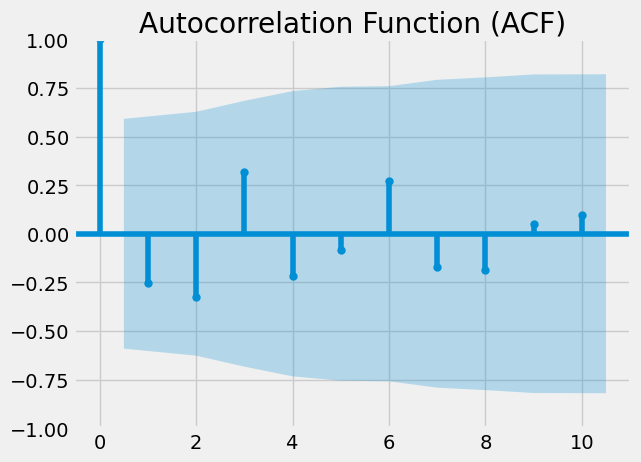

In [29]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# with my differenced series (stationary)
plot_acf(monthly_diff2, lags=10)
plt.title('Autocorrelation Function (ACF)')
plt.show()


# The vertical lines represent the lags in the series, while the blue area represents the confidence interval. Here lines are mostly below the blue edge of the confidence interval, this means that the data's behavior is consistent over time and that data is stationary, which supports the result of the second order Dickey-Fuller test conducted later on.

In [31]:
path = r'C:\Users\Apex PC\Desktop\DATA ANALYSIS\Achievement 6 project'

In [32]:
path

'C:\\Users\\Apex PC\\Desktop\\DATA ANALYSIS\\Achievement 6 project'

In [34]:
df_sub.to_csv(os.path.join(path, 'df_kc_6_6.csv'))